In [23]:
import pickle
import matplotlib.pyplot as plt
import json
import networkx as nx
import pandas as pd
import numpy as np
from dwave.system import DWaveSampler, FixedEmbeddingComposite
from dwave.samplers import SteepestDescentSolver, SimulatedAnnealingSampler, TabuSampler
import dwave.inspector

from plotters import plotHistogram, annotateSampleGraph, plotCSV, plotSampleGraph, plotArrangement
from qubo import createBQM
from sampleAnalysis import duplicates, findOverlaps, totalEntropy

identifier = "Haydn"
path = path = f"../Pickles/{identifier}/{identifier}_"

instruments = json.load(open(path + "instruments.json"))
phrases = pickle.load(open(path + "phrases.pkl", "rb"))
G = nx.read_graphml(path + "graph.graphml")
embedding = json.load(open(path + "embedding.json", "r"))
dwaveSampler = FixedEmbeddingComposite(DWaveSampler(), embedding)

In [27]:
reads = 500

bqm = createBQM(G, phrases, instruments, 6, 6, 1)
sampleset = dwaveSampler.sample(bqm, num_reads=reads, label=f"Haydn_{reads}", chain_strength=40)

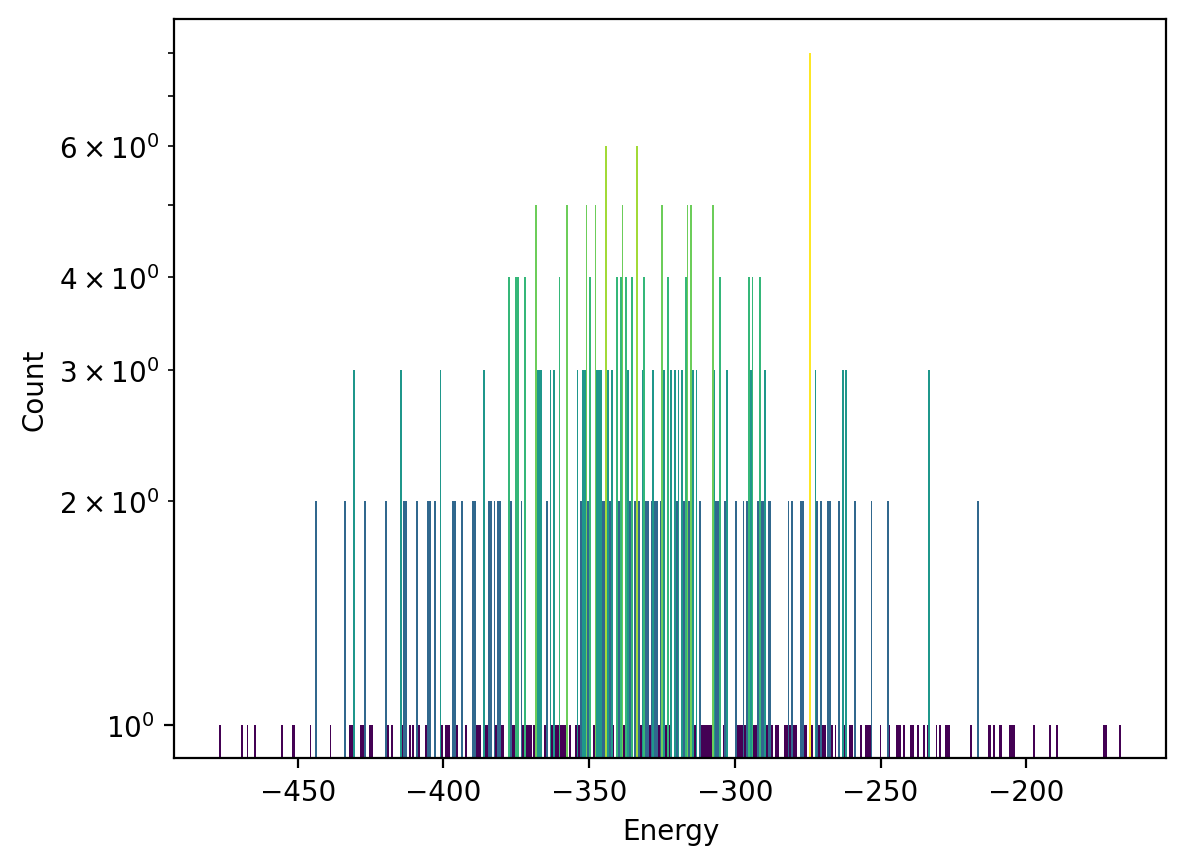

In [28]:
plotHistogram(sampleset.to_pandas_dataframe(True))

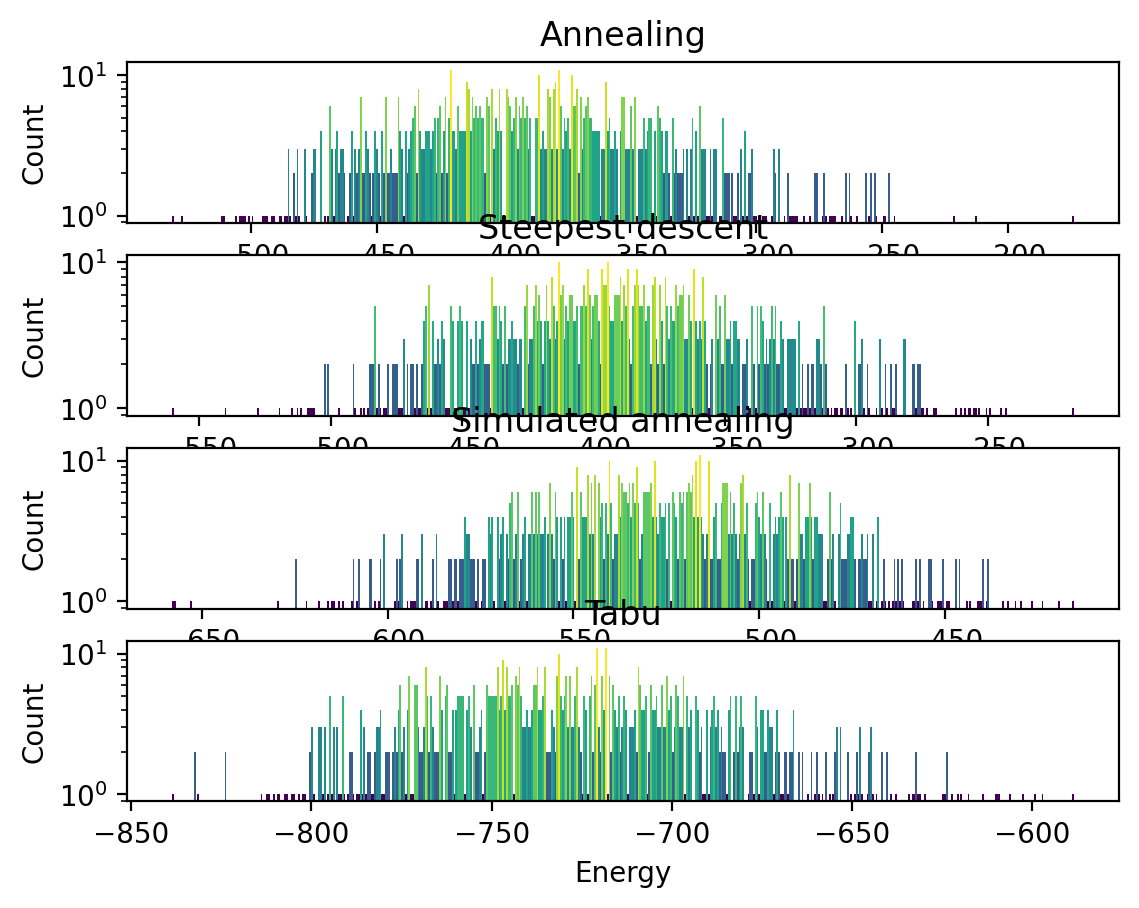

In [5]:
reads = 1000

results = dwaveSampler.sample(bqm, num_reads=reads, label=f"Haydn_{reads}").to_pandas_dataframe(True)
sd = SteepestDescentSolver().sample(bqm, num_reads=reads).to_pandas_dataframe(True)
sa = SimulatedAnnealingSampler().sample(bqm, num_reads=reads).to_pandas_dataframe(True)
ta = TabuSampler().sample(bqm, num_reads=reads).to_pandas_dataframe(True)

#random = RandomSampler().sample(bqm, num_reads=1000).to_pandas_dataframe(True)

plt.subplot(4, 1, 1)
plt.title("Annealing")
plotHistogram(results)
plt.subplot(4, 1, 2)
plt.title("Steepest descent")
plotHistogram(sd)
plt.subplot(4, 1, 3)
plt.title("Simulated annealing")
plotHistogram(sa)
plt.subplot(4, 1, 4)
plt.title("Tabu")
plotHistogram(ta)

plt.show()

In [7]:
ta = TabuSampler().sample(bqm, num_reads=reads)

print(f"Overlaps: {findOverlaps(annotateSampleGraph(ta.first.sample, G))}")
print(f"Duplicates: {len(duplicates(ta.first.sample, G))}")

Overlaps: 0
Duplicates: 0


In [15]:
def recordEnergyReads(readRange, bqm, sampler, filepath: str, quantum: bool = False):
    
    file = pd.DataFrame()
    for r in readRange:
        sampleset = sampler.sample(bqm, num_reads=r, label=f"Haydn_{r}")
        sample = sampleset.first

        A = annotateSampleGraph(sample.sample, G)

        if quantum:
            new_row = pd.DataFrame({
                "Total reads": [r],
                "QPU time": [sampleset.info["timing"]["qpu_access_time"]],
                "Chain strength": [sampleset.info["embedding_context"]["chain_strength"]],
                "Chain break fraction": [sample.chain_break_fraction],
                "Lowest energy": [bqm.energy(sample.sample)],
                "Total entropy": [totalEntropy(A)],
                "Overlaps": [findOverlaps(annotateSampleGraph(sample.sample, G))],
                "Duplicates": [len(duplicates(sample.sample, G))]
                })
        else:
            new_row = pd.DataFrame({
                "Total reads": [r],
                "Lowest energy": [bqm.energy(sample.sample)],
                "Total entropy": [totalEntropy(A)],
                "Overlaps": [findOverlaps(A)],
                "Duplicates": [len(duplicates(sample.sample, G))]
                })
    
        print(f"{r} reads recorded!")
        file = pd.concat([file, new_row])

    file.to_csv(filepath, index=False, mode="a", header=False)

bqm = createBQM(G, phrases, instruments, 6, 6, 1)
sa = SimulatedAnnealingSampler()
sd = SteepestDescentSolver()
ta = TabuSampler()
recordEnergyReads(np.arange(500,3501,500), bqm, ta, path+"ta-reads.csv", quantum=False)

500 reads recorded!
1000 reads recorded!
1500 reads recorded!
2000 reads recorded!
2500 reads recorded!
3000 reads recorded!
3500 reads recorded!


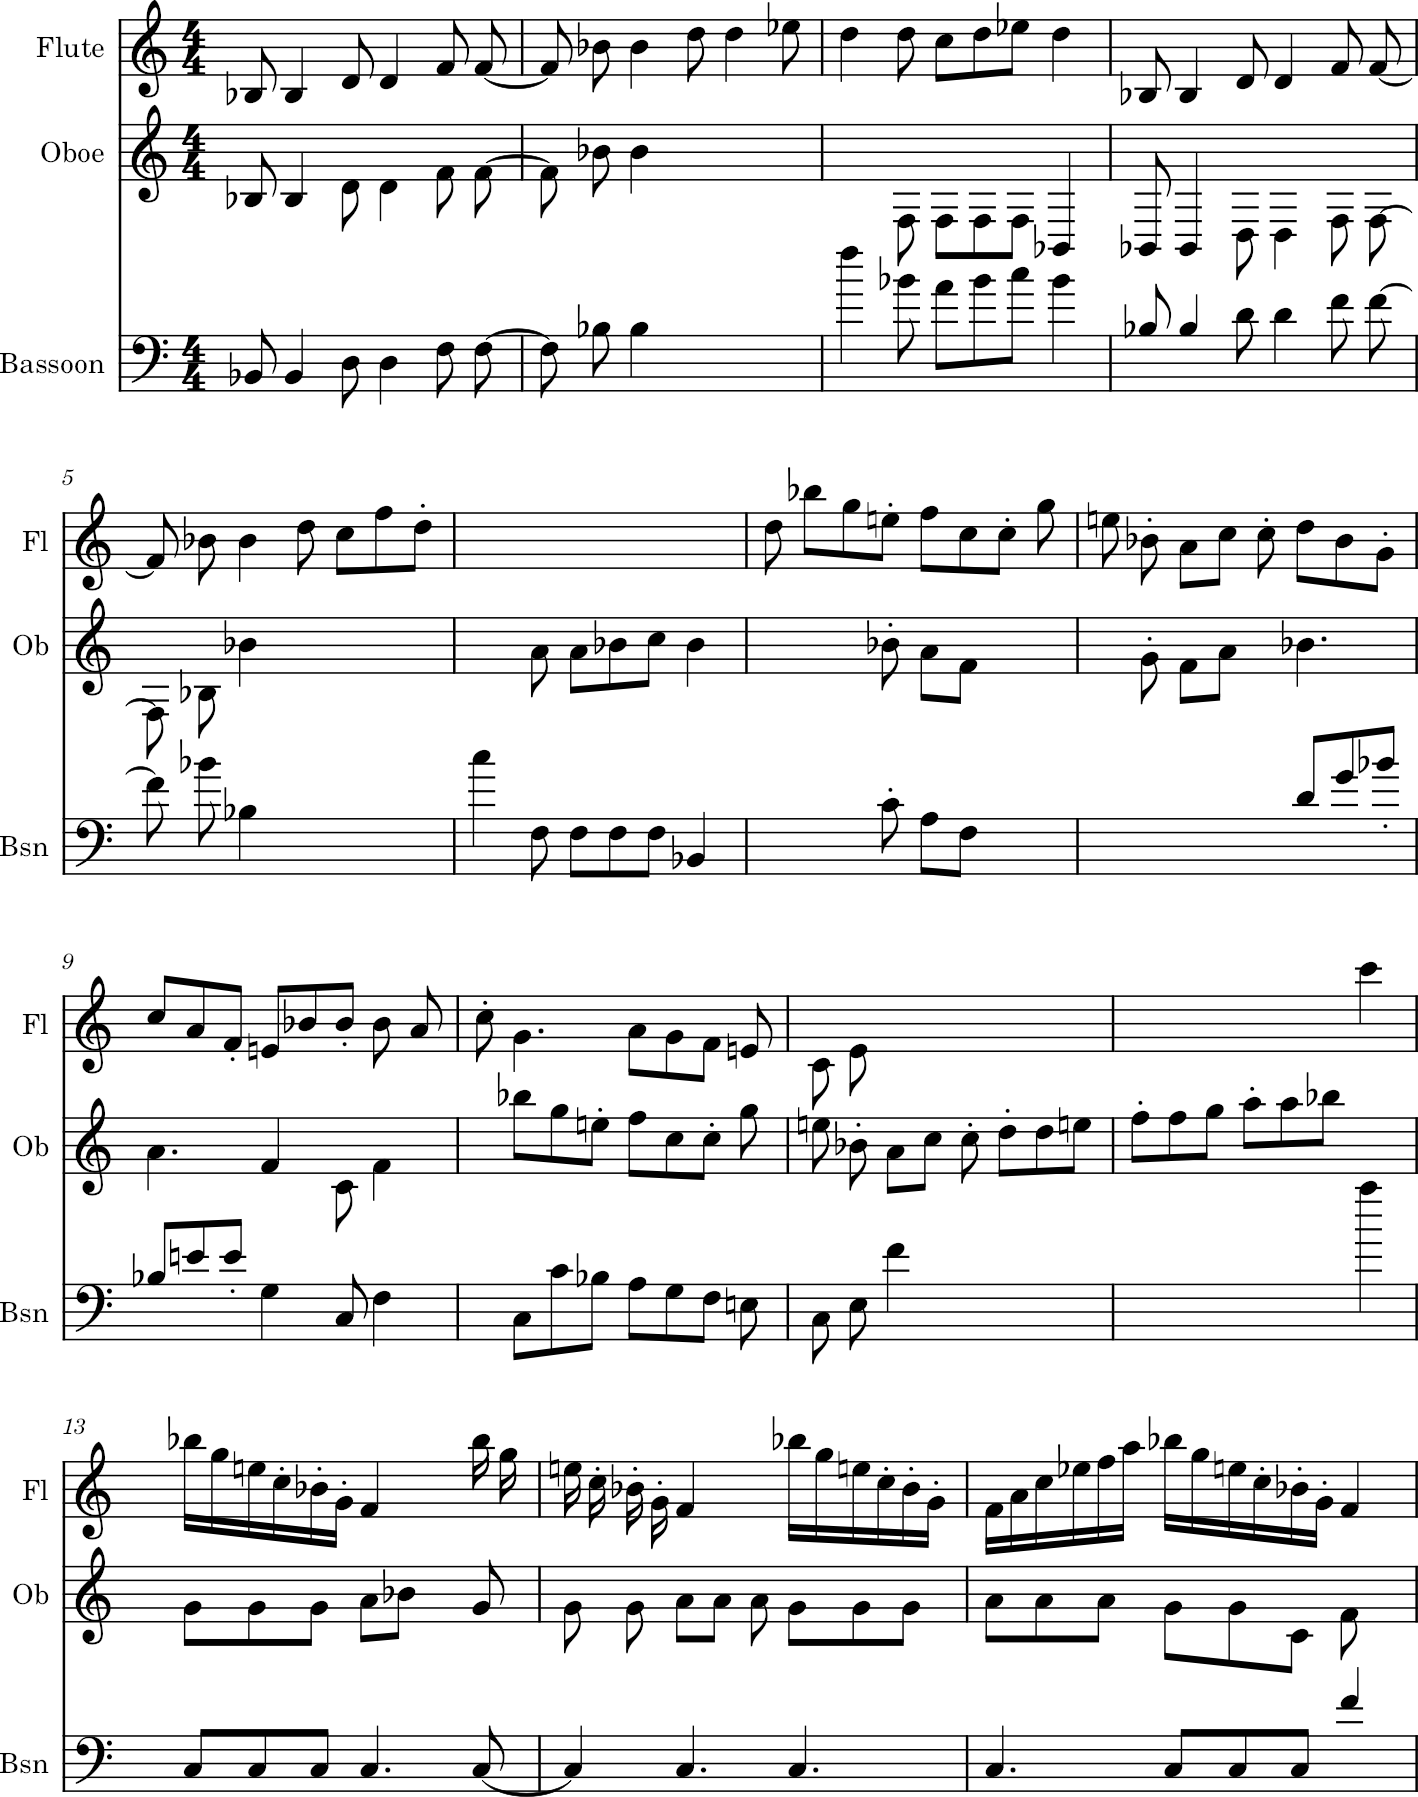

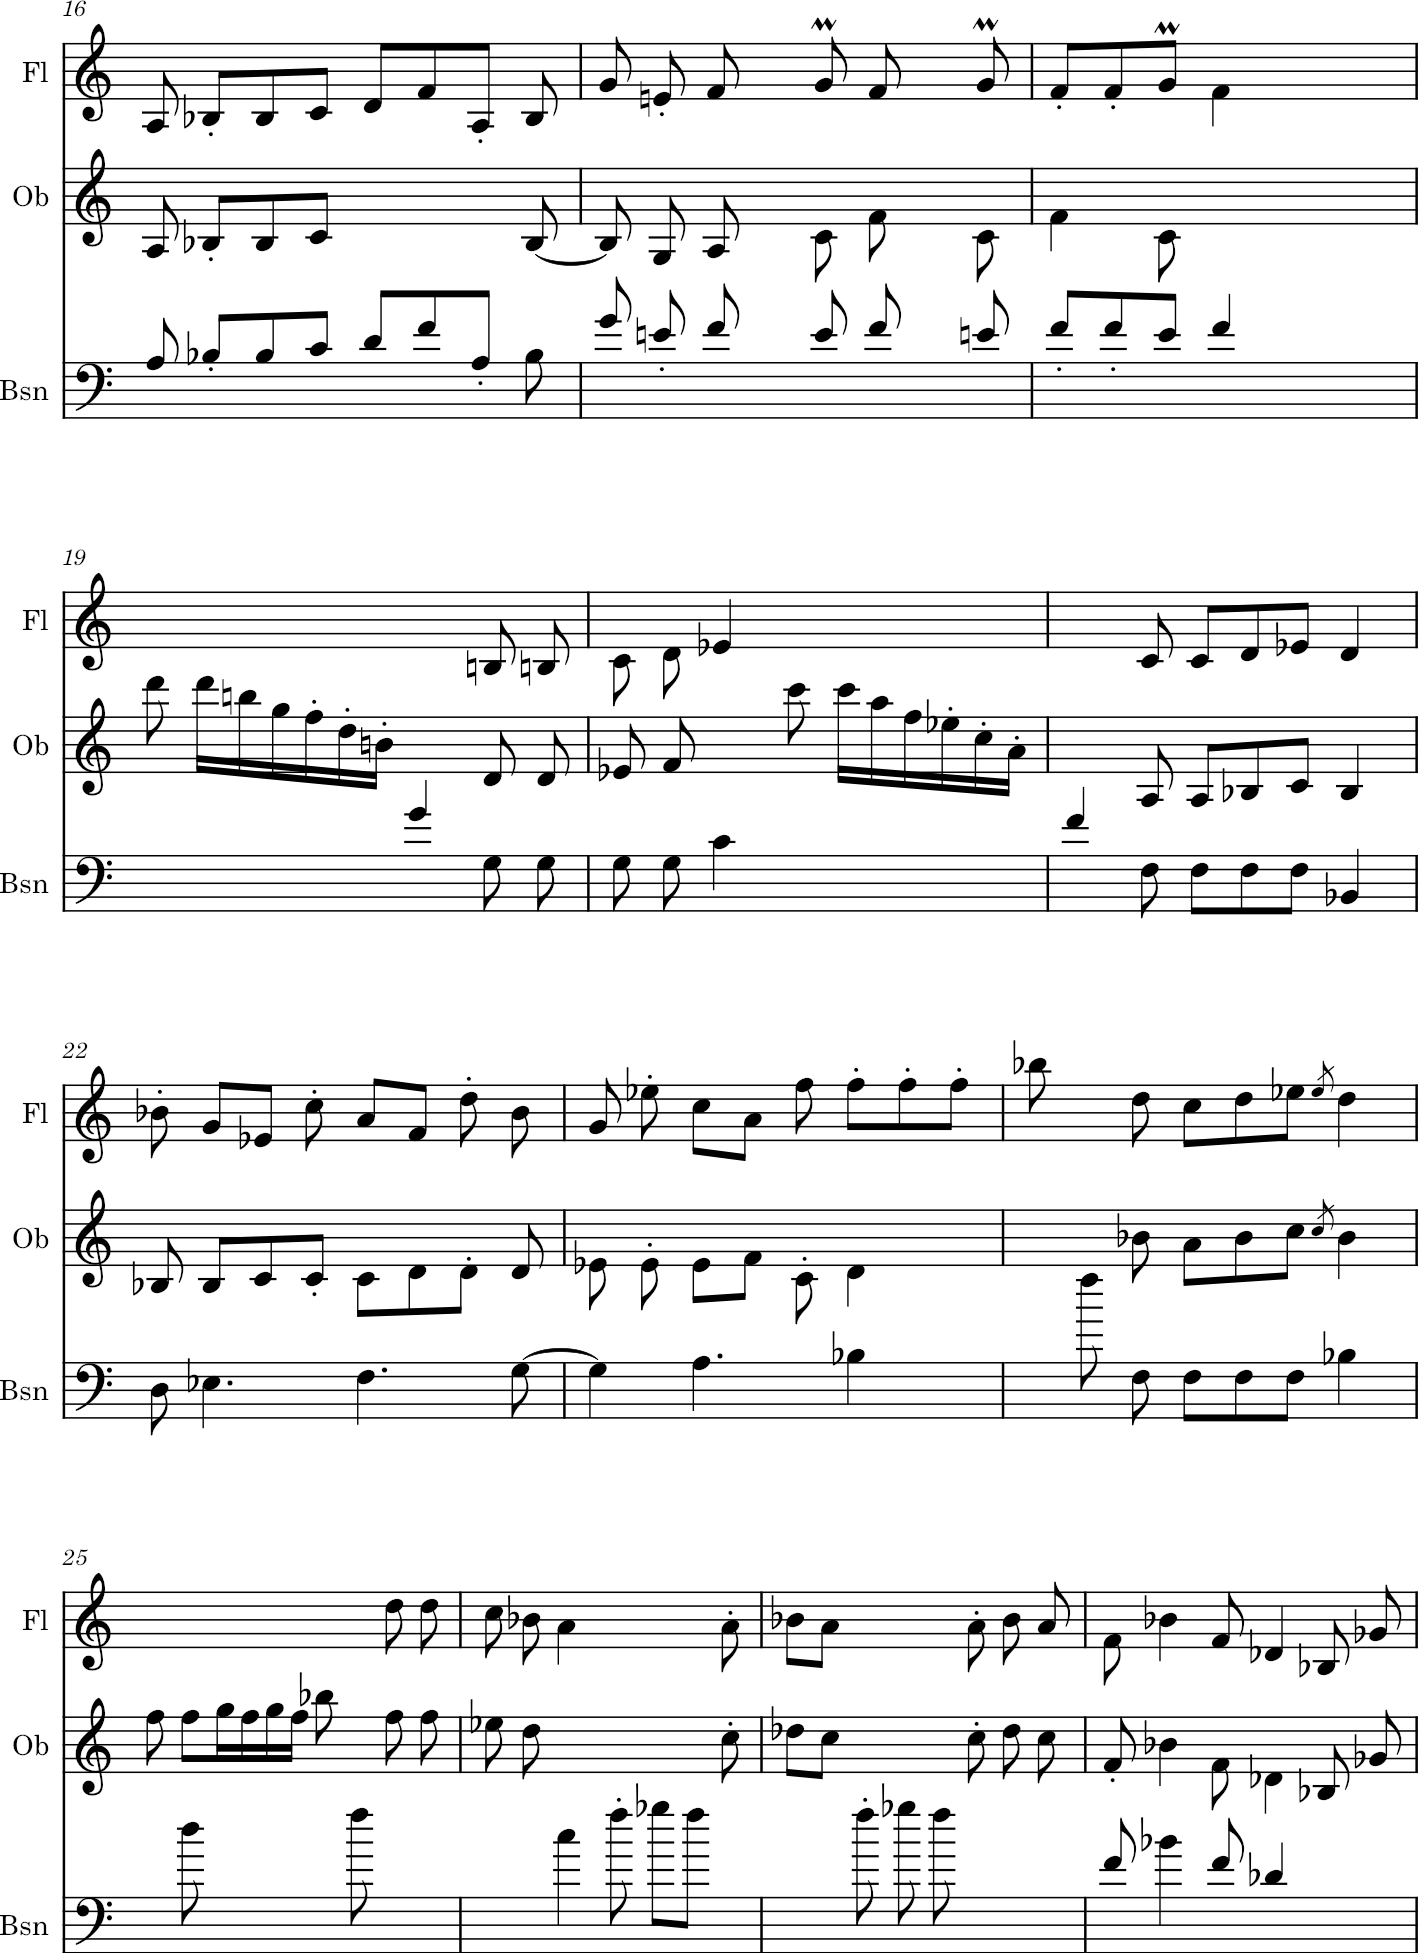

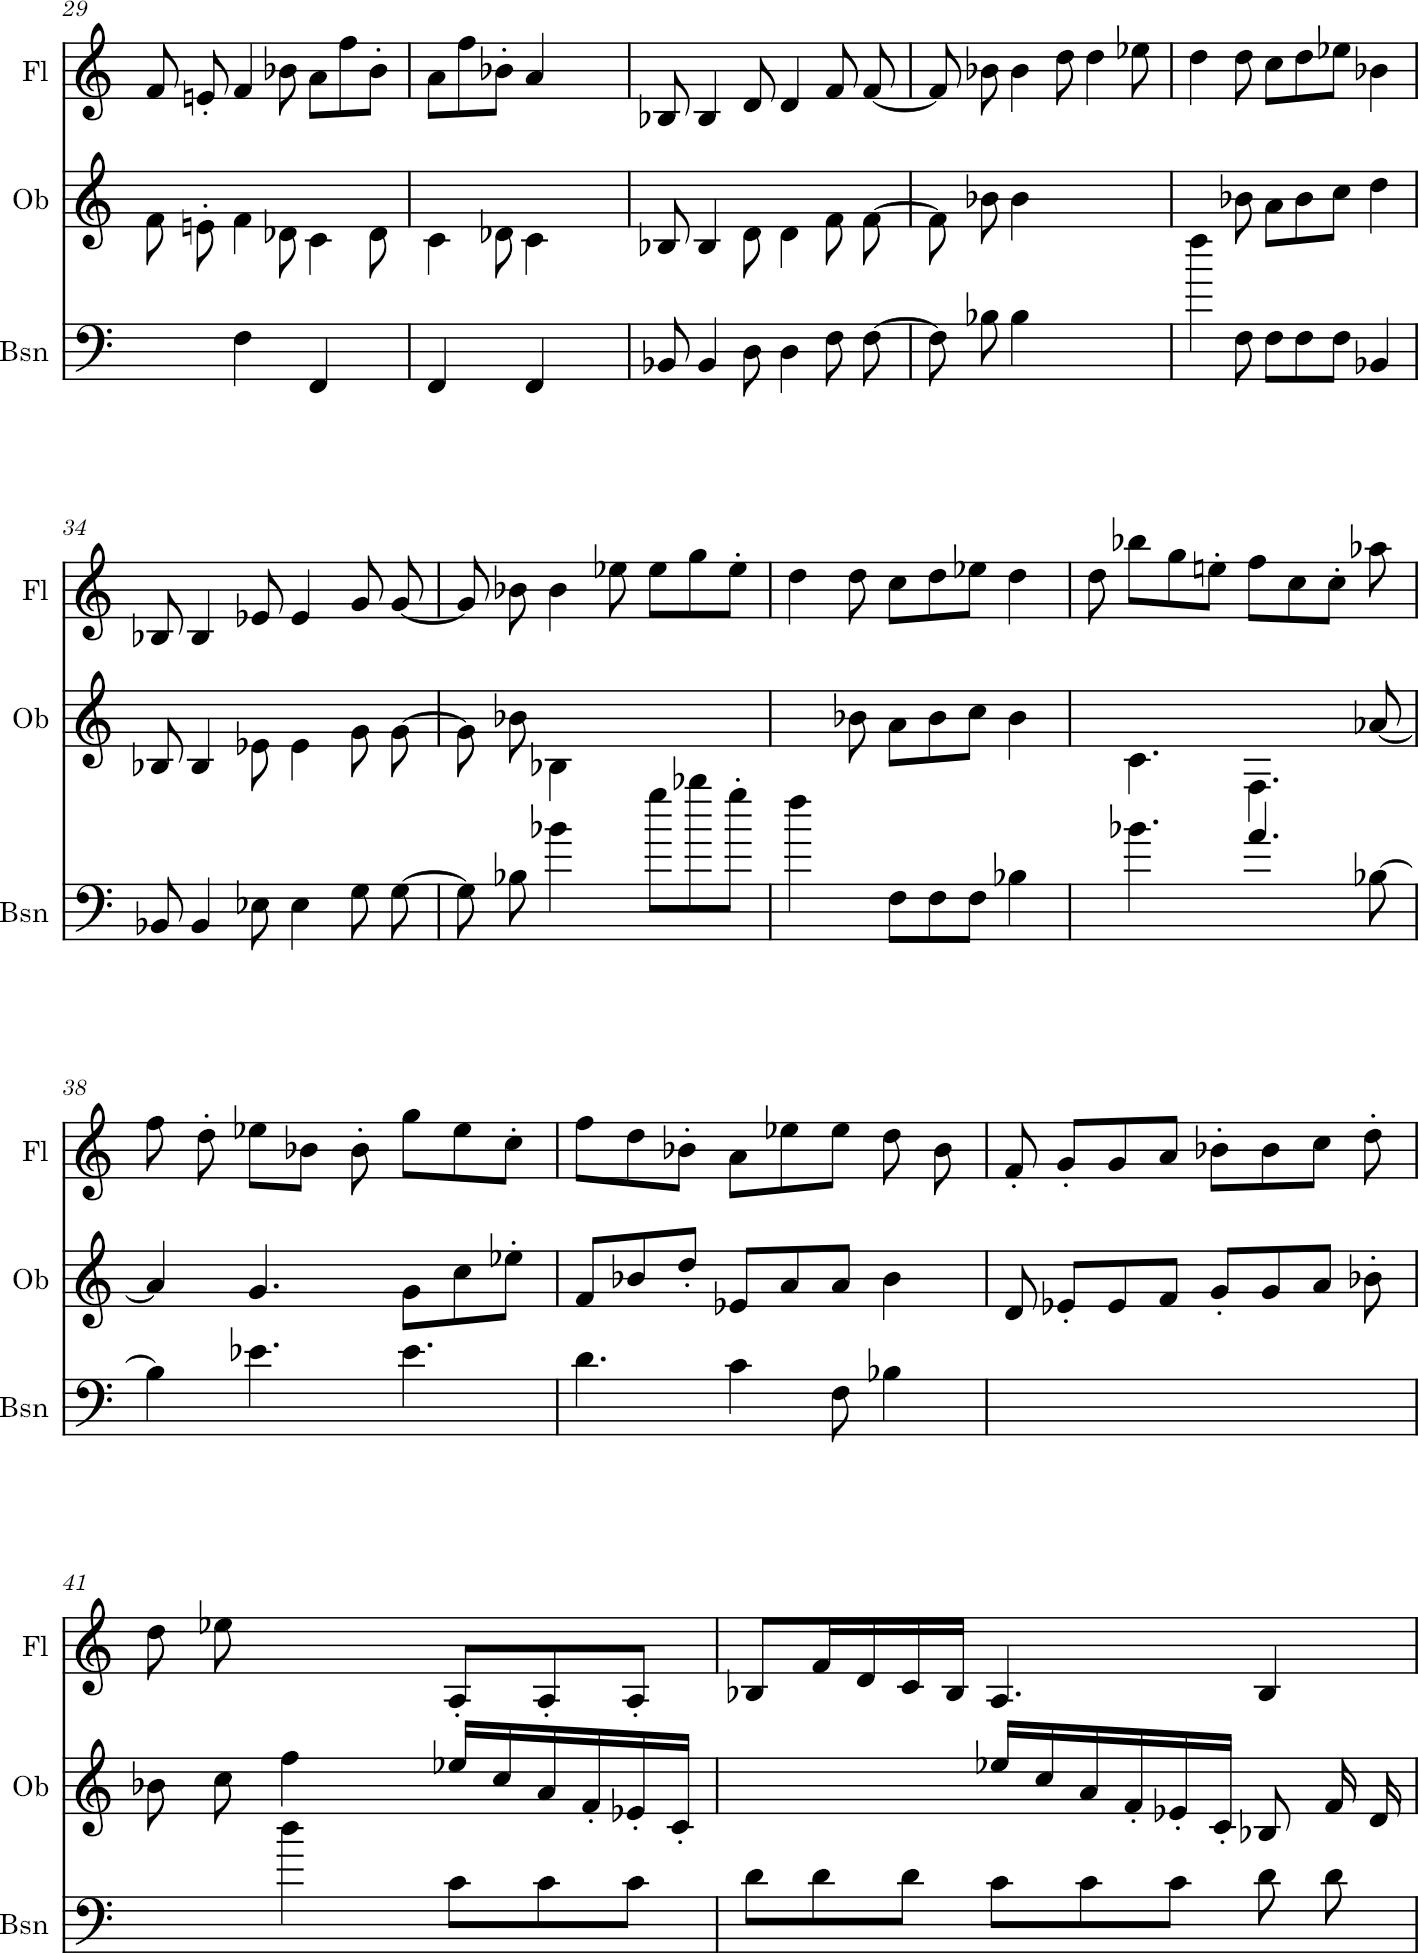

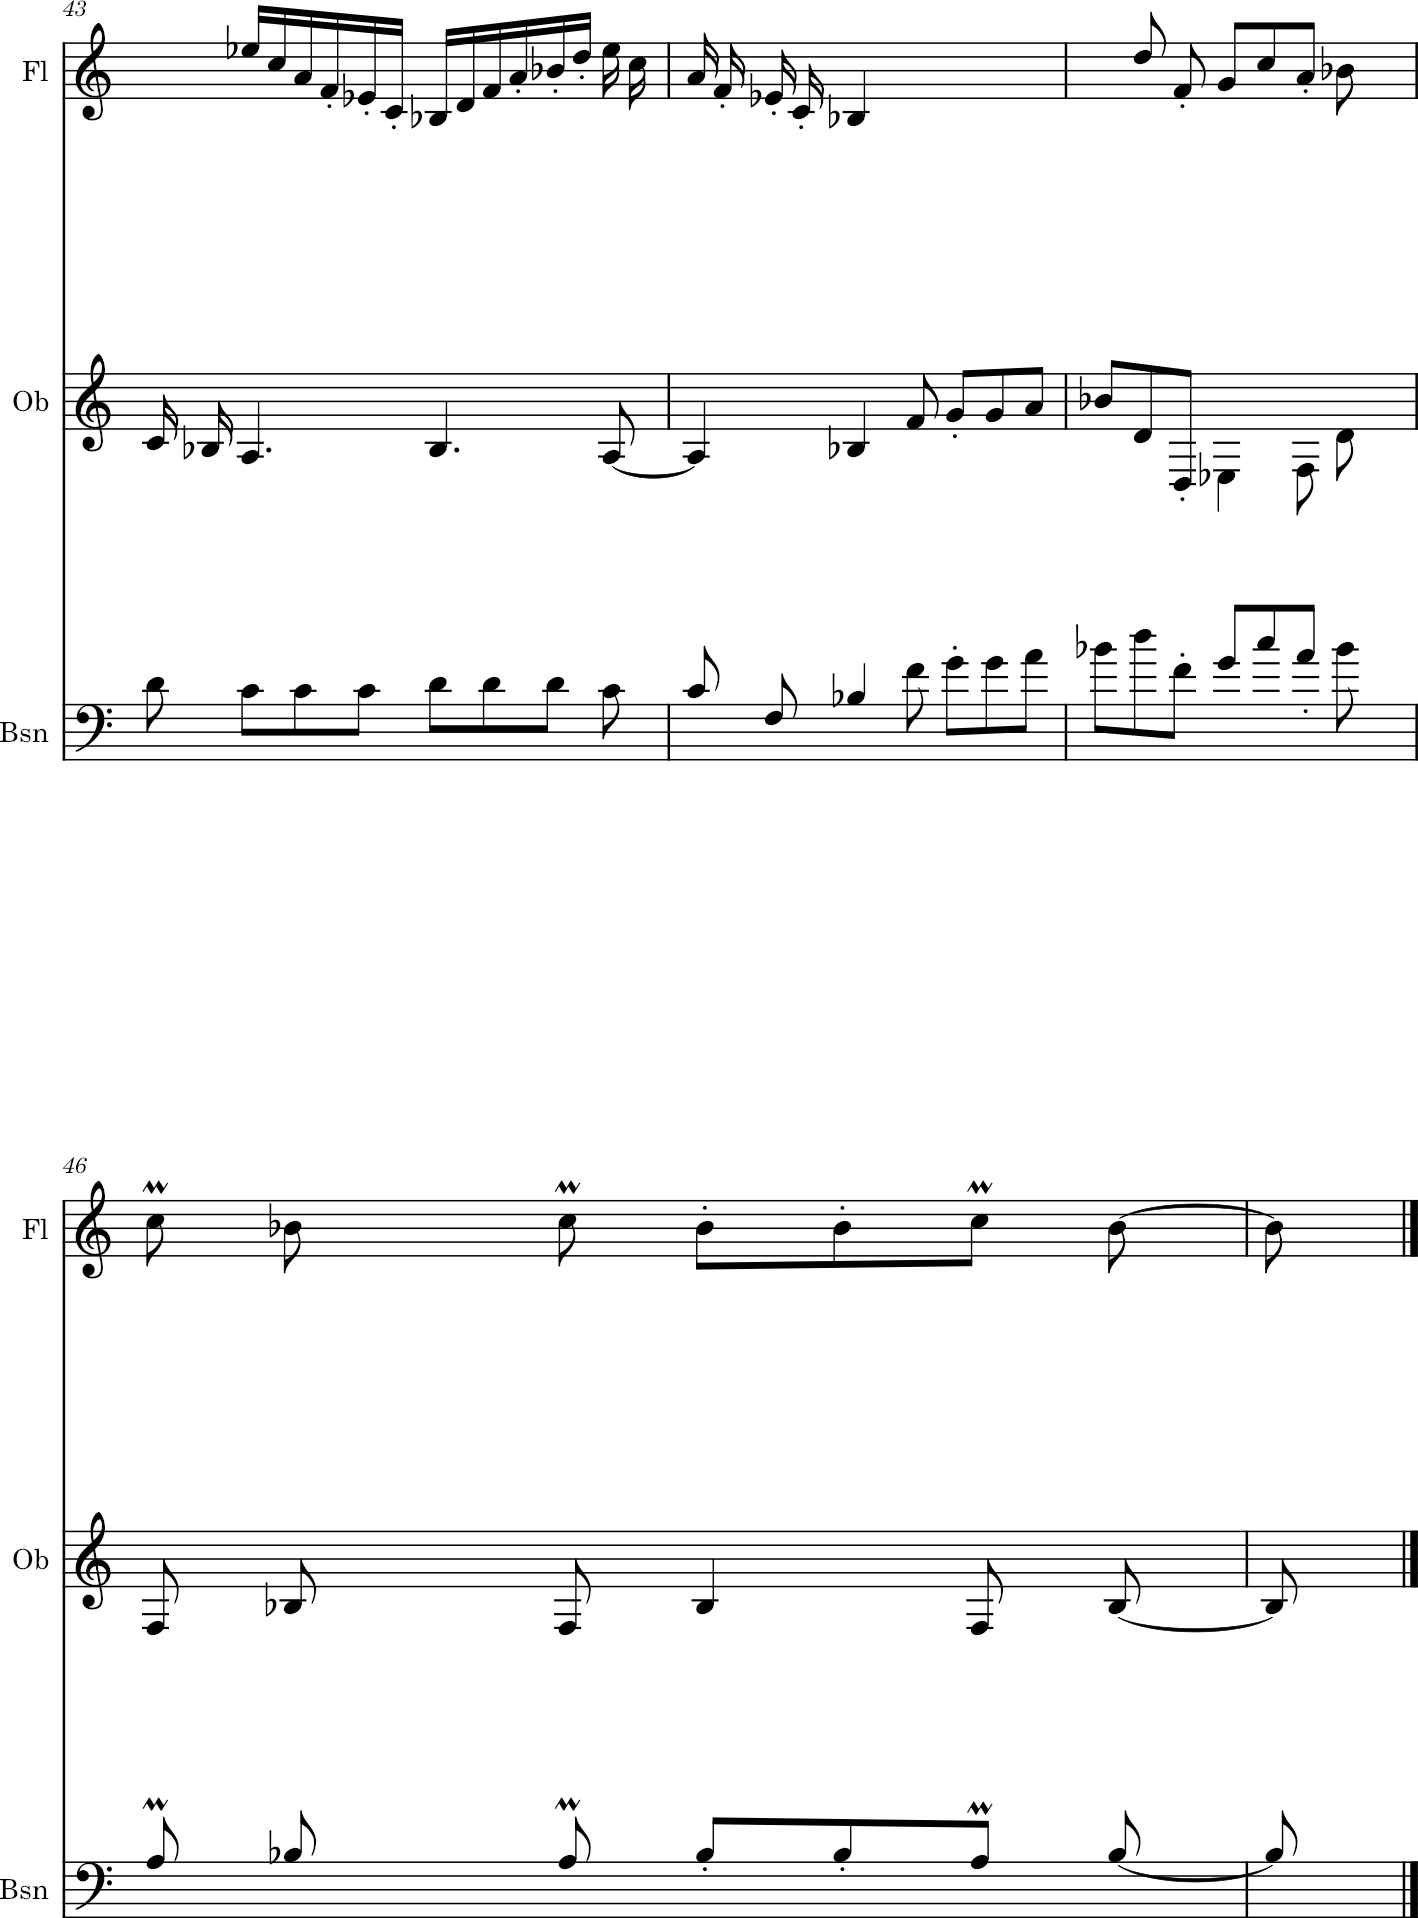

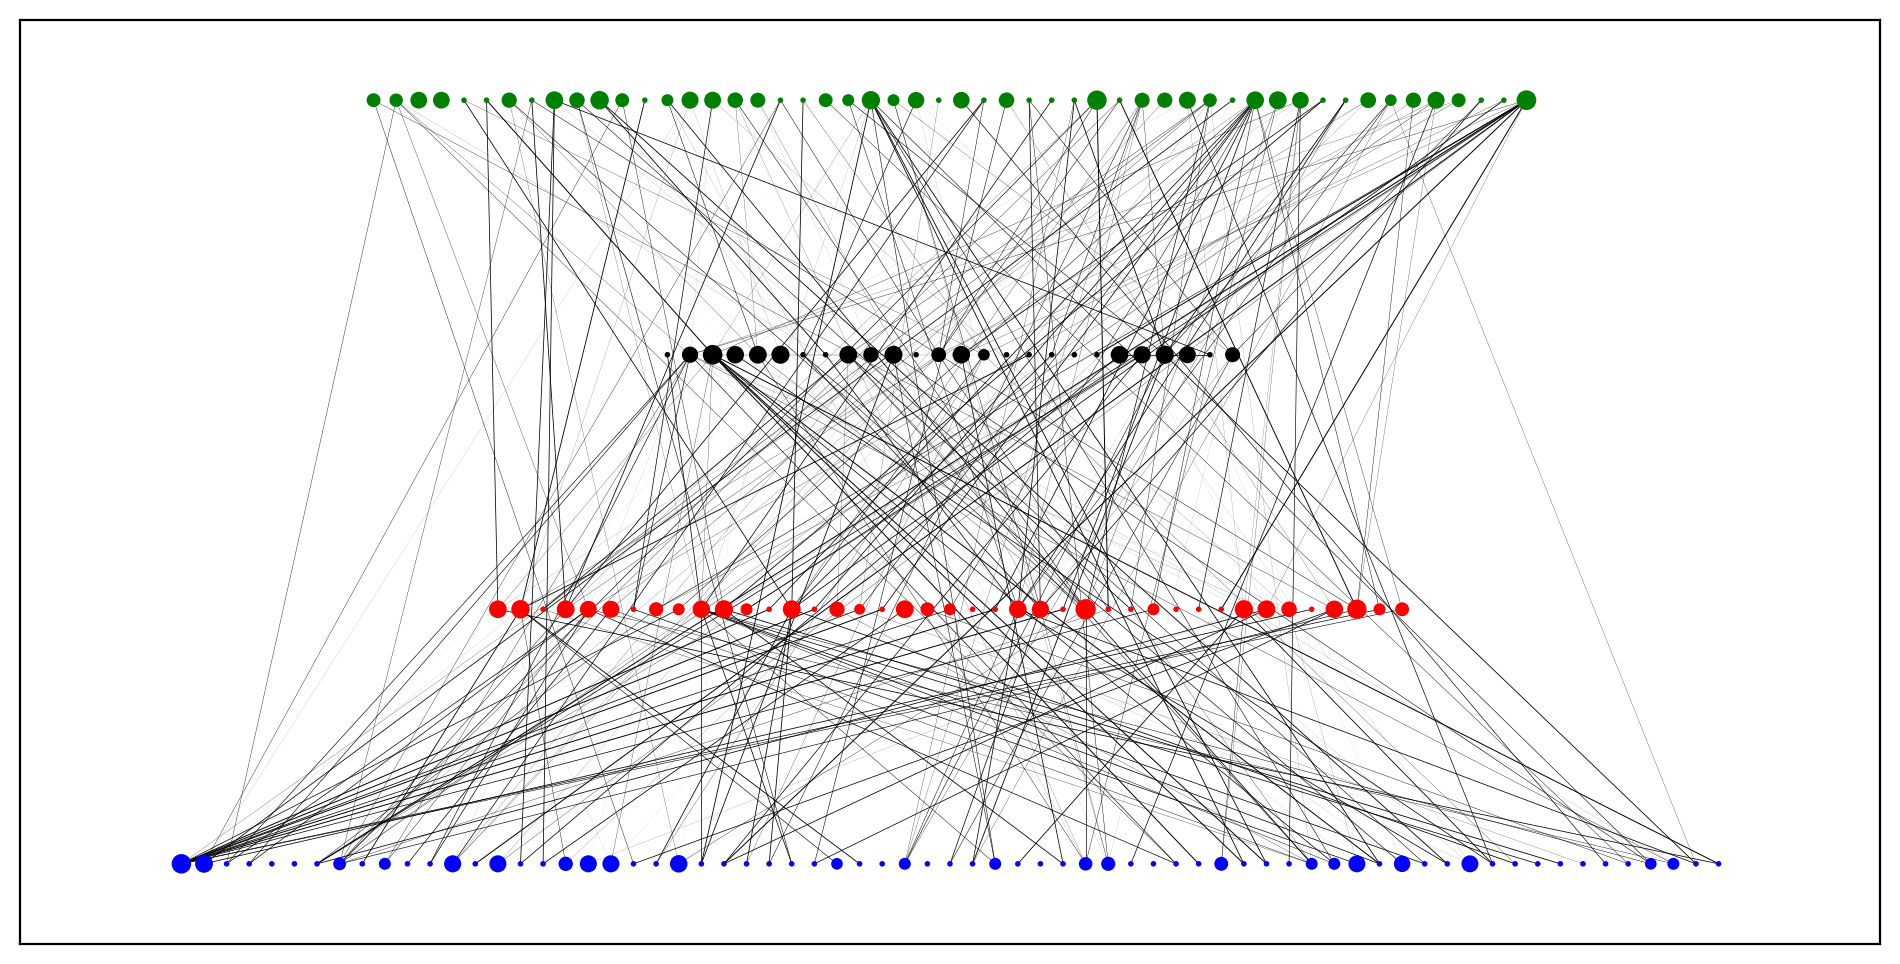

In [24]:
sampleset = ta.sample(bqm, num_reads=500)
plotSampleGraph(sampleset.first.sample, G, instruments)
plotArrangement(sampleset.first.sample, phrases, instruments)

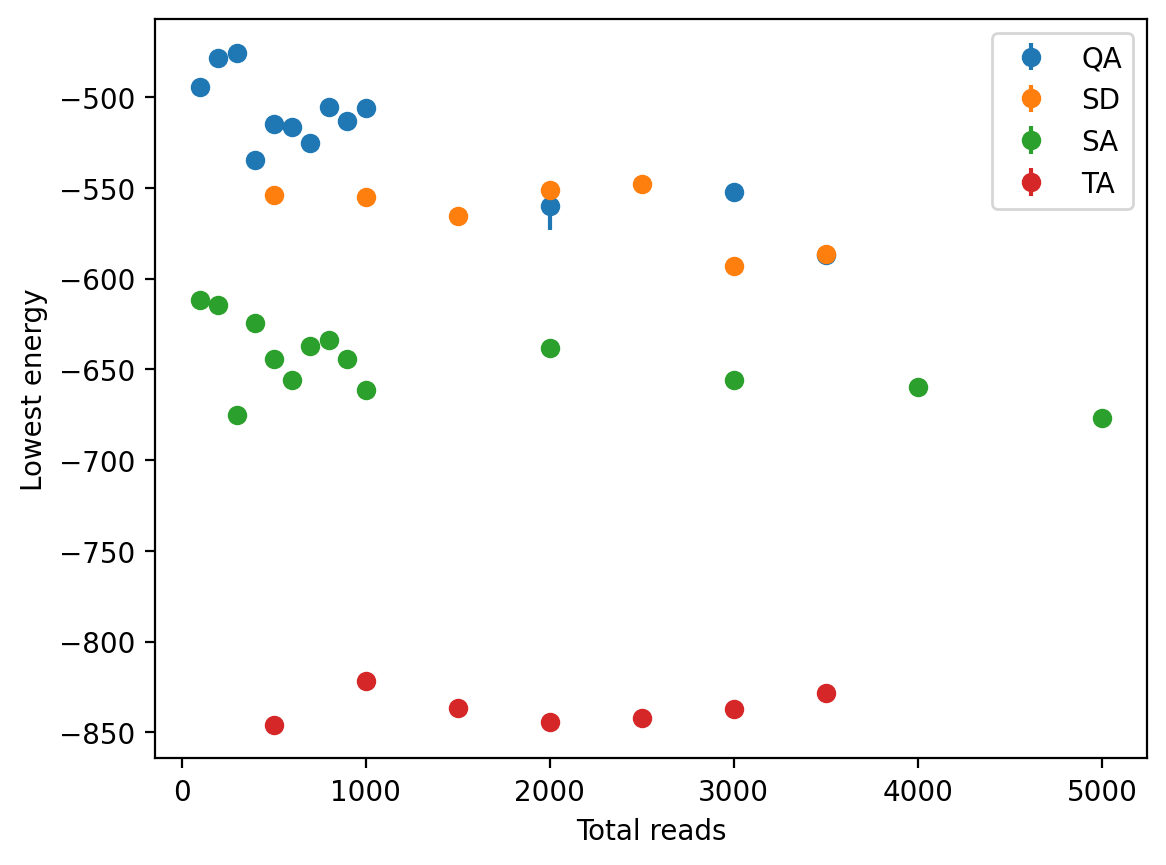

In [ ]:
def compareAll(yaxis: str):

    plotCSV(path+"qa-reads.csv", "Total reads", yaxis, "QA")
    plotCSV(path+"sd-reads.csv", "Total reads", yaxis, "SD")
    plotCSV(path+"sa-reads.csv", "Total reads", yaxis, "SA")
    plotCSV(path+"ta-reads.csv", "Total reads", yaxis, "TA")
    plt.legend()
    plt.show()

# Tabu has lowest energy and higher entropy and score looks a lot better
# Maybe annealer chain strength should change?
compareAll("Lowest energy")
#plotSampleGraph(sampleset.first.sample, G, instruments)
#dwave.inspector.show(sampleset)

In [3]:
# Both correctly maximise total node weight (-212.02...)
# Both maximise node and edge weight (-1891.18...)
# Both maximise node and edge weight with adjacent vertices different colours (QA does better than SD but not SA) (~-247)
# There was a bug in edge weighting, didn't import `iter` module :(

print(results.sort_values("energy").head()[["energy", "chain_break_fraction", "num_occurrences"]])
print(sd.sort_values("energy").head()[["energy", "num_steps"]])
print(sa.sort_values("energy").head()[["energy", "num_occurrences"]])

       energy  chain_break_fraction  num_occurrences
0 -772.675996                   0.0                1
1 -772.311570                   0.0                1
2 -772.147580                   0.0                1
3 -769.460196                   0.0                1
4 -767.919210                   0.0                1
         energy  num_steps
338 -706.750272        260
173 -701.519107        285
221 -697.734129        284
371 -695.478581        272
127 -691.179245        281
         energy  num_occurrences
430 -814.240683                1
178 -812.328425                1
275 -811.918959                1
359 -811.567582                1
104 -811.286553                1
